In [1]:
import BioSimSpace as BSS
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
import glob
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import  GridSpec

import numpy as np
from itertools import chain
import os
import shutil
from functools import reduce

from rdkit import Chem
from importlib import reload

/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 17.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jscheen/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/j

In [2]:
# clear everything from the LOMAP directory environment. 
# BSS/LOMAP seems to be overwriting/reusing some data when restarting the kernel.
for file in glob.glob("process/lomap/lomap_inputs*"):
    os.remove(file)
try:
    for folder in glob.glob("process/lomap/*"):
        shutil.rmtree(folder)
except NotADirectoryError:
    pass

In [3]:
exclude_intermediate = True # restart kernel after changing.
fep_nn_exclude_outliers = False

# Analyse a single congeneric series: TYK2
## File preparation
Write a links file for all types of LOMAP input that we can generate, including LOMAP-Scores.

In [4]:
def loadFEPNNPredictions(path_to_preds, clip_fepnn_outliers):
    """Loads a simple CSV file containing FEPNN predictions of SEM per edge. Clips outliers if specified."""
    df = pd.read_csv(path_to_preds)
    
    if clip_fepnn_outliers:
        print("Clipping FEPNN prediction outliers.")
        percentiles = df["pred_sem_mean"].quantile([0.01, 0.99]).values
        df["pred_sem_mean"] = np.clip(df["pred_sem_mean"], percentiles[0], percentiles[1])
    
    return df

In [5]:
def generateLinksFiles(preds_path, base_model_preds_paths, true_path, clip_fepnn_outliers):
    """Given a csv file with SEM predictions and a csv file with true SEM values, return 
    information for links files for LOMAP.
    Because SEMs are the inverse of LOMAP (i.e. LOMAP-score 0.0 is poor, but SEM 0.0 is good), 
    we need to invert the predicted SEM values. Additionally, compress them to fall in the range 0-1 
    as is the case with LOMAP-scores."""
    true_perts = pd.read_csv(true_path)[["lig_1", "lig_2"]].values
    true_perts = [ f"{pert[0]}~{pert[1]}" for pert in true_perts]
    true_sems = pd.read_csv(true_path)["error"].values
    true_df = pd.DataFrame()
    true_df["pert_name"] = true_perts
    true_df["true_sem"] = true_sems
    #true_df['true_sem'][true_df['true_sem'] >= 0.5] = 0.5  # this makes ML perform even worse.
    
    # load the FEP-NN predicted SEMs.
    
    sem_preds = [loadFEPNNPredictions(preds_path, clip_fepnn_outliers)]
    
    # load the base model predicted SEMs.
    for base_model_pred_path in glob.glob(base_model_preds_paths):
        method_name = "_".join(base_model_pred_path.split("/")[-1].split("_")[1:3]).upper()
        base_df = pd.read_csv(base_model_pred_path)
        base_df.columns = ["pert_name", method_name]
        
        # now scale the predicted SEMs to 0-1. 
        base_df[method_name] = minmax_scale(1 /  base_df[method_name].values, feature_range=(0,1))
        sem_preds.append(base_df)
        
    # merge all the predictions together.
    preds_df = reduce(lambda  left,right: pd.merge(left,right,on=['pert_name'],
                                            how='outer'), sem_preds)
    
    # add preds and true SEMs together into one DF; replace failed true SEMs with max(SEM)
    combined_df = pd.merge(preds_df, true_df, on=["pert_name"], how="outer").fillna(max(true_sems))
    pert_names = combined_df["pert_name"].values
       
    
    # for these, take inverse and scale to 0-1.
    true_sems = minmax_scale(1 /  combined_df["true_sem"].values, feature_range=(0,1))
    pred_sems = minmax_scale(1 / combined_df["pred_sem_mean"].values, feature_range=(0,1))

    random_sems = combined_df["random_sem"].values
    ecfp6_sems = combined_df["fp_similarity"].values
    
    # also get all base model arrays.
    APFP_RF = combined_df["APFP_RF"].values
    ECFP_RF = combined_df["ECFP_RF"].values
    PROPS_RF = combined_df["PROPS_RF"].values  
        
    APFP_SVR = combined_df["APFP_SVR"].values
    ECFP_SVR = combined_df["ECFP_SVR"].values
    PROPS_SVR = combined_df["PROPS_SVR"].values
    
    return pert_names, true_sems, pred_sems, APFP_RF, ECFP_RF, PROPS_RF, APFP_SVR, ECFP_SVR, PROPS_SVR, \
            random_sems, ecfp6_sems, combined_df, combined_df[["pert_name","true_sem"]]
      
    
    
def writeLinksFile(pert_names, values, filename):
    with open(filename, "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
        for pert_name, value in zip(pert_names, values):
            writer.writerow([pert_name, value])


In [6]:
# Get all values and write them to links files so that we can feed them to LOMAP.      
pert_names, true_sems, pred_sems, APFP_RF, ECFP_RF, PROPS_RF, APFP_SVR, ECFP_SVR, PROPS_SVR, \
    random_sems, ecfp6_sems, combined_df, true_df = generateLinksFiles(
                                                "output/series_predictions/tyk2.csv",
                                                "output/series_predictions/base_models/tyk2_*",
                                                "input/testsets/tyk2/ALL_TRUE_SEMS_BI_PROPD.csv",
                                                fep_nn_exclude_outliers
                                                )

writeLinksFile(pert_names, true_sems, "process/lomap/lomap_inputs_true_sems.csv")
writeLinksFile(pert_names, pred_sems, "process/lomap/lomap_inputs_pred_sems.csv")
writeLinksFile(pert_names, random_sems, "process/lomap/lomap_inputs_rand_sems.csv")
writeLinksFile(pert_names, ecfp6_sems, "process/lomap/lomap_inputs_ecfp6_sems.csv")

# base models.
writeLinksFile(pert_names, APFP_RF, "process/lomap/lomap_inputs_APFP_RF_sems.csv")
writeLinksFile(pert_names, ECFP_RF, "process/lomap/lomap_inputs_ECFP_RF_sems.csv")
writeLinksFile(pert_names, PROPS_RF, "process/lomap/lomap_inputs_PROPS_RF_sems.csv")

writeLinksFile(pert_names, APFP_SVR, "process/lomap/lomap_inputs_APFP_SVR_sems.csv")
writeLinksFile(pert_names, ECFP_SVR, "process/lomap/lomap_inputs_ECFP_SVR_sems.csv")
writeLinksFile(pert_names, PROPS_SVR, "process/lomap/lomap_inputs_PROPS_SVR_sems.csv")

In [7]:
# run LOMAP on the TYK2 set so that we can grab the scores.
try:
    work_dir_path = "process/lomap/lomap_workdir"
    shutil.rmtree(work_dir_path)
except FileNotFoundError:
    pass

path_to_ligands = "input/testsets/tyk2/ligands"
ligand_files = glob.glob(f"{path_to_ligands}/*.sdf")

ligands = []
ligand_names = []

for filepath in ligand_files:
    if exclude_intermediate:
        if "intermediate" in filepath:
            continue
    # append the molecule object to a list.
    ligands.append(Chem.SDMolSupplier(filepath)[0])
    
    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))

tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=False, names=ligand_names, 
                                                         work_dir=work_dir_path)

In [8]:
# instead of the normal approach (see BSS tutorial), find the LOMAP score for 
# the fully-connected network in the work_dir.
lomap_perts = []
lomap_scores = []

with open("process/lomap/lomap_workdir/outputs/lomap_score_with_connection.txt", "r") as lomap_file:
    reader = csv.reader(lomap_file)
    next(reader)
    for row in reader:
        cleaned_row = [ item.replace(" ","") for item in row ]
        
        lig1 = "_".join(cleaned_row[2].split("_")[1:]).split(".")[0]
        lig2 = "_".join(cleaned_row[3].split("_")[1:]).split(".")[0]
        pert = lig1+"~"+lig2
        lomap_score = float(cleaned_row[4])
        lomap_perts.append(pert)
        lomap_scores.append(lomap_score)
        
        # lomap's mtx edges are monodirectional, but our predictions are bidirectional. Write both directions.
        inv_pert = lig2+"~"+lig1
        lomap_perts.append(inv_pert)
        lomap_scores.append(lomap_score)        
        
writeLinksFile(lomap_perts, lomap_scores, "process/lomap/lomap_inputs_lomap_scores.csv")

## Analyse SEM correlations
Plot all possible combinations of data in scatterplots, i.e. lomap, true sem, pred sem, rand sem.


In [9]:
true_sems_df = pd.read_csv("process/lomap/lomap_inputs_true_sems.csv", names=["Perturbation", "True SEM [0-1]"], sep=" ")
pred_sems_df = pd.read_csv("process/lomap/lomap_inputs_pred_sems.csv", names=["Perturbation", "ML-Predicted\nSEM [0-1]"], sep=" ")
rand_sems_df = pd.read_csv("process/lomap/lomap_inputs_rand_sems.csv", names=["Perturbation", "Random\nSEM [0-1]"], sep=" ")
ecfp6_sems_df = pd.read_csv("process/lomap/lomap_inputs_ecfp6_sems.csv", names=["Perturbation", "ECFP6 Tanimoto Sim."], sep=" ")

APFP_RF_df = pd.read_csv("process/lomap/lomap_inputs_APFP_RF_sems.csv", names=["Perturbation", "APFP_RF [0-1]"], sep=" ")
ECFP_RF_df = pd.read_csv("process/lomap/lomap_inputs_ECFP_RF_sems.csv", names=["Perturbation", "ECFP_RF [0-1]"], sep=" ")
PROPS_RF_df = pd.read_csv("process/lomap/lomap_inputs_PROPS_RF_sems.csv", names=["Perturbation", "PROPS_RF [0-1]"], sep=" ")
APFP_SVR_df = pd.read_csv("process/lomap/lomap_inputs_APFP_SVR_sems.csv", names=["Perturbation", "APFP_SVR [0-1]"], sep=" ")
ECFP_SVR_df = pd.read_csv("process/lomap/lomap_inputs_ECFP_SVR_sems.csv", names=["Perturbation", "ECFP_SVR [0-1]"], sep=" ")
PROPS_SVR_df = pd.read_csv("process/lomap/lomap_inputs_PROPS_SVR_sems.csv", names=["Perturbation", "PROPS_SVR [0-1]"], sep=" ")

lomap_sems_df = pd.read_csv("process/lomap/lomap_inputs_lomap_scores.csv", names=["Perturbation", "LOMAP-Score"], sep=" ")

# add the number of heavy atoms perturbed.
num_ha = combined_df[["pert_name", "num_ha_change"]]
num_ha.columns = ["Perturbation","Heavy Atoms Perturbed"]

# create a single dataframe.
sems_combined_df = reduce(lambda left,right: pd.merge(left,right,on='Perturbation'), 
      [true_sems_df, rand_sems_df, pred_sems_df, ecfp6_sems_df, lomap_sems_df, num_ha, 
       APFP_RF_df, ECFP_RF_df, PROPS_RF_df, APFP_SVR_df, ECFP_SVR_df, PROPS_SVR_df])

# drop duplicates.
#sems_combined_df.drop_duplicates(subset="Perturbation", inplace=True)
sems_combined_df

,Perturbation,True SEM [0-1],Random\nSEM [0-1],ML-Predicted\nSEM [0-1],ECFP6 Tanimoto Sim.,LOMAP-Score,Heavy Atoms Perturbed,APFP_RF [0-1],ECFP_RF [0-1],PROPS_RF [0-1],APFP_SVR [0-1],ECFP_SVR [0-1],PROPS_SVR [0-1]
0,lig_ejm_44~lig_ejm_49,0.001171,0.592206,0.179630,0.777778,0.20190,6,0.222195,0.677091,0.067804,0.218078,0.370466,0.336416
1,lig_ejm_49~lig_ejm_44,0.044447,0.592206,0.179630,0.777778,0.20190,6,0.222195,0.677091,0.067804,0.218078,0.370466,0.336416
2,lig_ejm_44~lig_ejm_55,0.034543,0.310726,0.207621,0.819048,0.77880,4,0.755367,0.447261,0.016185,0.593917,0.334552,0.684178
3,lig_ejm_55~lig_ejm_44,0.042703,0.310726,0.207621,0.819048,0.77880,4,0.755367,0.447261,0.016185,0.593917,0.334552,0.684178
4,lig_ejm_44~lig_jmc_28,0.000000,0.157418,0.161079,0.781818,0.24660,6,0.664348,0.764850,0.042835,0.304644,0.321941,0.480780
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,lig_ejm_42~lig_ejm_48,0.038500,0.211552,0.226776,0.770642,0.27253,5,0.540227,0.624208,0.121428,0.301446,0.550981,0.769556
236,lig_ejm_48~lig_jmc_23,0.055036,0.861730,0.228111,0.824561,0.04066,1,0.565901,0.594064,0.201359,0.066143,0.371705,0.490040
237,lig_jmc_23~lig_ejm_48,0.017158,0.861730,0.228111,0.824561,0.04066,1,0.565901,0.594064,0.201359,0.066143,0.371705,0.490040
238,lig_ejm_42~lig_jmc_23,0.085408,0.576631,0.201184,0.770642,0.30119,6,0.508017,0.387842,0.163380,0.511926,0.969919,0.203705


In [10]:
def computeStats(input_df):
    """return statistics input for table to plot."""
    col_labels = ["Random", "ECFP6", "APFP\nRF", "ECFP\nRF", "PROPS\nRF", "APFP\nSVR", "ECFP\nSVR", "PROPS\nSVR", "$\widehat{SEM}^{scaled}$", "LOMAP"]
    row_labels = ["Pearson r", "MUE /\nkcal$\cdot$mol$^{-1}$", r"Kendall $\tau$"]
    table_vals = []
    for array in [input_df["Random\nSEM [0-1]"],
                  input_df["ECFP6 Tanimoto Sim."],
                  input_df["APFP_RF [0-1]"],
                  input_df["ECFP_RF [0-1]"],
                  input_df["PROPS_RF [0-1]"],
                  input_df["APFP_SVR [0-1]"],
                  input_df["ECFP_SVR [0-1]"],
                  input_df["PROPS_SVR [0-1]"],
                  input_df["ML-Predicted\nSEM [0-1]"],
                  input_df["LOMAP-Score"]
                 ]:
        

        r = round(stats.pearsonr(input_df["True SEM [0-1]"], array)[0], 2)
        mue = round(mean_absolute_error(input_df["True SEM [0-1]"], array), 2)
        tau = round(stats.kendalltau(input_df["True SEM [0-1]"], array)[0], 2)
        table_vals.append([r, mue, tau])
        
    # need to transpose table values to fit the row/col layout.
    table_vals = np.array(table_vals).T.tolist()
    return col_labels, row_labels, table_vals
col_labels, row_labels, table_vals = computeStats(sems_combined_df)

In [11]:
# remove intermediate
if exclude_intermediate:
    sems_combined_df = sems_combined_df[~sems_combined_df.Perturbation.str.contains("intermediate")]

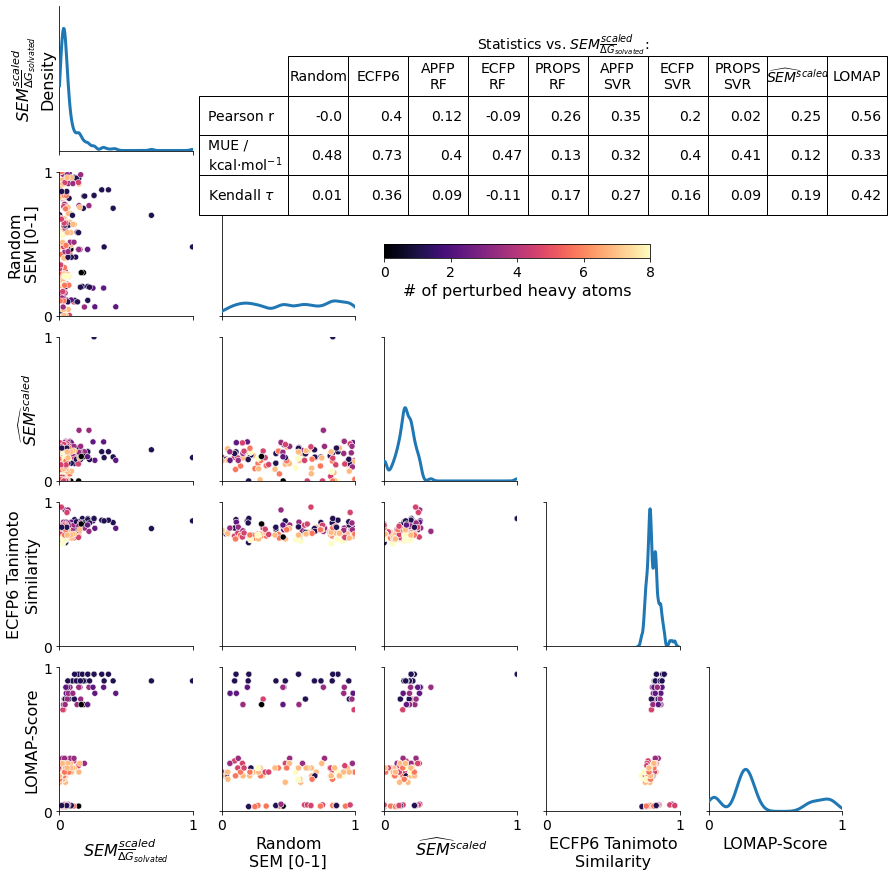

In [12]:
data = sems_combined_df.iloc[:, : 7] # don't plot the base_models correlations, only include them in table.

# make a pairplot.
new_column_names = ['Perturbation', '$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$', 'Random\nSEM [0-1]',
       '$\widehat{SEM}^{scaled}$', 'ECFP6 Tanimoto\nSimilarity', 'LOMAP-Score',
       'Heavy Atoms Perturbed']
data.columns = new_column_names
g = sns.PairGrid(data, hue="Heavy Atoms Perturbed", palette='magma')
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, hue=None, bw_adjust=0.5, clip=(0.0, 1.0))

# $SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$
# $\widehat{SEM}^{scaled}$

# create the colorbar.
norm = plt.Normalize(data["Heavy Atoms Perturbed"].min(), data["Heavy Atoms Perturbed"].max()+1)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])

axins = inset_axes(g.axes.flatten()[7],
                   width="200%",  # width = 5% of parent_bbox width
                   height="10%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0.0, 0.4, 1, 1),
                   bbox_transform=g.axes.flatten()[7].transAxes,
                   borderpad=0,
                   )

cbar = g.figure.colorbar(sm, shrink=1.5, cax=axins, orientation="horizontal")
cbar.set_label('# of perturbed heavy atoms')


# hide empty graphs.
for i, ax in enumerate(g.axes.flatten()):
    if i in [1, 2, 3, 4, 7, 8, 9, 13, 14, 19]:
        ax.axis("off")
        

#adjust ticks such that each plot just shows 0 and 1.
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(1))
    ax.yaxis.set_major_locator(plt.MaxNLocator(1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
# Hide y ticks in true SEM density plot to avoid confusion.
g.axes.flatten()[0].set_yticks([])
g.axes.flatten()[0].set_ylabel("$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$\nDensity")


# create a table with statistics.
table = g.axes.flatten()[6].table(cellText=table_vals,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.5, 0.7, 4.5, 1.1], zorder=100)
table.auto_set_font_size(False)
table.set_fontsize(14)


g.axes.flatten()[2].annotate("Statistics vs. $SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$:",xy=(0.7,0.7))
plt.show()

## Network generation and analysis
Generate networks with links_files. Run a LOMAP function for each. Compute Sum of SEMs for each.

In [13]:
def runLOMAP(links_file):
    """
    For a given links file, runs LOMAP using the edge scorings specified in the file. Returns
    information on the generated network (edges, ligand names etc). Broadly speaking, this function
    uses a working directory for LOMAP to run in, then parses some of the files that LOMAP outputs.
    """
    runner_work_dir = "process/lomap/lomap_runner_workdir/"
    if os.path.exists(runner_work_dir):
        shutil.rmtree(runner_work_dir)
        
    # run LOMAP on the set so that we can grab the scores.
    path_to_ligands = "input/testsets/tyk2/ligands"
    ligand_files = glob.glob(f"{path_to_ligands}/*.sdf")

    ligands = []
    ligand_names = []

    for filepath in ligand_files:
        if exclude_intermediate:
            if "intermediate" in filepath: # remove intermediate from network generation.
                continue
            
        # append the molecule object to a list.
        ligands.append(Chem.SDMolSupplier(filepath)[0])

        # append the molecule name to another list so that we can use the name of each molecule in our workflow.
        ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))

    # bit of a workaround, but we have to find the SDF file names that LOMAP uses internally.  
    # write out a second linksfile that doesn't have the tilde to denote the perturbations. Also
    # use glob in the pre-generated LOMAP work folder to find what we should call our ligands (i.e.
    # refer to the internal LOMAP file name).
    links_file_contents = pd.read_csv(links_file, sep=" ", header=None)
    lomap_internal_files = glob.glob("process/lomap/lomap_workdir/inputs/*.sdf")
    internal_links_file_path = links_file.replace(".csv", "_internal.csv")

    with open(internal_links_file_path, "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
              
        for pert_name, value in zip(links_file_contents[0].values, links_file_contents[1].values):
            if exclude_intermediate:
                if "intermediate" in pert_name:
                    continue
                    
            # find the internal path.
            for lig in lomap_internal_files:
                if pert_name.split("~")[0] in lig:
                    lig1 = lig.split("/")[-1].replace(".sdf.sdf",".sdf") # not sure why this is happening.
                elif pert_name.split("~")[1] in lig:
                    lig2 = lig.split("/")[-1].replace(".sdf.sdf",".sdf") 
                              
            writer.writerow([lig1, lig2, value])
    
    
    # now run LOMAP with the pre-specified edge scorings.
    tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=False, names=ligand_names,
                                                            links_file=internal_links_file_path,
                                                            work_dir=runner_work_dir)
    
    pert_network_dict = {}
    transformations_named = [(ligand_names[transf[0]], ligand_names[transf[1]]) for transf in tranformations]
    for transf, score in zip(transformations_named, lomap_scores):
        transf_tilde = "~".join(transf)
        pert_network_dict[transf_tilde] = score
    
    return tranformations, lomap_scores, pert_network_dict

In [14]:
def calcTrueSEMS(pert_network_dict, true_sems_df, true_sem_input=False):
    """Given a specific combination of edges, computes the True SEMs in the network."""
    true_sems_per_edge = []
    perts = []
    for pert, v in pert_network_dict.items():
        if true_sem_input:
            # in case we are dealing with True SEM input to LOMAP, the pert_network_dict will
            # already contain true SEMs as scores. return these instead of parsing the reference DF. 
            sem_this_pert = v
        else:
            # from the dataframe with true sems, find the true sem for this edge that LOMAP has suggested.
            try:
                sem_this_pert = true_sems_df[true_sems_df["Perturbation"] == pert]["True SEM"].values[0]
            except IndexError:
                inv_pert = f"{pert.split('~')[1]}~{pert.split('~')[0]}"
                sem_this_pert = true_sems_df[true_sems_df["Perturbation"] == inv_pert]["True SEM"].values[0]

        true_sems_per_edge.append(sem_this_pert)
        perts.append(pert)

    
    return true_sems_per_edge, len(true_sems_per_edge), perts

In [15]:
_, lomap_scores_random, pert_network_dict_random = runLOMAP("process/lomap/lomap_inputs_rand_sems.csv")
_, lomap_scores_pred, pert_network_dict_pred = runLOMAP("process/lomap/lomap_inputs_pred_sems.csv")
_, lomap_scores_lomap, pert_network_dict_lomap = runLOMAP("process/lomap/lomap_inputs_lomap_scores.csv")
_, lomap_scores_ecfp6, pert_network_dict_ecfp6 = runLOMAP("process/lomap/lomap_inputs_ecfp6_sems.csv")
_, lomap_scores_true_sem, pert_network_dict_true_sem = runLOMAP("process/lomap/lomap_inputs_true_sems.csv")

_, lomap_scores_APFP_RF, pert_network_dict_APFP_RF= runLOMAP("process/lomap/lomap_inputs_APFP_RF_sems.csv")
_, lomap_scores_ECFP_RF, pert_network_dict_ECFP_RF = runLOMAP("process/lomap/lomap_inputs_ECFP_RF_sems.csv")
_, lomap_scores_PROPS_RF, pert_network_dict_PROPS_RF = runLOMAP("process/lomap/lomap_inputs_PROPS_RF_sems.csv")

_, lomap_scores_APFP_SVR, pert_network_dict_APFP_SVR= runLOMAP("process/lomap/lomap_inputs_APFP_SVR_sems.csv")
_, lomap_scores_ECFP_SVR, pert_network_dict_ECFP_SVR = runLOMAP("process/lomap/lomap_inputs_ECFP_SVR_sems.csv")
_, lomap_scores_PROPS_SVR, pert_network_dict_PROPS_SVR = runLOMAP("process/lomap/lomap_inputs_PROPS_SVR_sems.csv")

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.5922060460636359'] -> (0, 1) score 0.5922060460636359
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.5922060460636359'] -> (1, 0) score 0.5922060460636359
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.3107255004232699'] -> (0, 2) score 0.3107255004232699
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.3107255004232699'] -> (2, 0) score 0.3107255004232699
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.1574178211677576'] -> (0, 3) score 0.1574178211677576
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.1574178211677576'] -> (3, 0) score 0.1574178211677576
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.4068254520556924'] -> (0, 4) score 0.4068254520556924
Added prespecified link for mols ['004_lig_ejm_43.sdf',

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.179630408273637'] -> (0, 1) score 0.179630408273637
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.179630408273637'] -> (1, 0) score 0.179630408273637
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.2076214470404263'] -> (0, 2) score 0.2076214470404263
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.2076214470404263'] -> (2, 0) score 0.2076214470404263
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.1610788483712963'] -> (0, 3) score 0.1610788483712963
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.1610788483712963'] -> (3, 0) score 0.1610788483712963
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.1903390408239561'] -> (0, 4) score 0.1903390408239561
Added prespecified link for mols ['004_lig_ejm_43.sdf', '00

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.2019'] -> (0, 1) score 0.2019
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.2019'] -> (1, 0) score 0.2019
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.7788'] -> (0, 2) score 0.7788
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.7788'] -> (2, 0) score 0.7788
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.2466'] -> (0, 3) score 0.2466
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.2466'] -> (3, 0) score 0.2466
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.90484'] -> (0, 4) score 0.90484
Added prespecified link for mols ['004_lig_ejm_43.sdf', '000_lig_ejm_44.sdf', '0.90484'] -> (4, 0) score 0.90484
Added prespecified link for mols ['000_lig_ejm_44.sdf', '005_lig_ejm_50.sdf', '0.7788'] -> (0, 5) score 0.77

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.7777777777777778'] -> (0, 1) score 0.7777777777777778
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.7777777777777778'] -> (1, 0) score 0.7777777777777778
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.819047619047619'] -> (0, 2) score 0.819047619047619
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.819047619047619'] -> (2, 0) score 0.819047619047619
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.7818181818181819'] -> (0, 3) score 0.7818181818181819
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.7818181818181819'] -> (3, 0) score 0.7818181818181819
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.8113207547169812'] -> (0, 4) score 0.8113207547169812
Added prespecified link for mols ['004_lig_ejm_43.sdf', '00

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.0011707429016699'] -> (0, 1) score 0.0011707429016699
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.0444465800372861'] -> (1, 0) score 0.0444465800372861
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.0345432323416112'] -> (0, 2) score 0.0345432323416112
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.0427026766191108'] -> (2, 0) score 0.0427026766191108
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.0'] -> (0, 3) score 0.0
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.0073810741174423'] -> (3, 0) score 0.0073810741174423
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.0952311252802611'] -> (0, 4) score 0.0952311252802611
Added prespecified link for mols ['004_lig_ejm_43.sdf', '000_lig_ejm_44.sdf', '0.1214

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.2221953983979223'] -> (0, 1) score 0.2221953983979223
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.2221953983979223'] -> (1, 0) score 0.2221953983979223
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.7553669972157593'] -> (0, 2) score 0.7553669972157593
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.7553669972157593'] -> (2, 0) score 0.7553669972157593
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.6643483873217368'] -> (0, 3) score 0.6643483873217368
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.6643483873217368'] -> (3, 0) score 0.6643483873217368
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.3586442514622425'] -> (0, 4) score 0.3586442514622425
Added prespecified link for mols ['004_lig_ejm_43.sdf',

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.677090561572588'] -> (0, 1) score 0.677090561572588
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.677090561572588'] -> (1, 0) score 0.677090561572588
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.4472610112107297'] -> (0, 2) score 0.4472610112107297
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.4472610112107297'] -> (2, 0) score 0.4472610112107297
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.7648498181649735'] -> (0, 3) score 0.7648498181649735
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.7648498181649735'] -> (3, 0) score 0.7648498181649735
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.5968881704198112'] -> (0, 4) score 0.5968881704198112
Added prespecified link for mols ['004_lig_ejm_43.sdf', '00

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.0678043662527701'] -> (0, 1) score 0.0678043662527701
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.0678043662527701'] -> (1, 0) score 0.0678043662527701
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.0161850106033449'] -> (0, 2) score 0.0161850106033449
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.0161850106033449'] -> (2, 0) score 0.0161850106033449
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.0428354980625159'] -> (0, 3) score 0.0428354980625159
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.0428354980625159'] -> (3, 0) score 0.0428354980625159
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.0901695402503208'] -> (0, 4) score 0.0901695402503208
Added prespecified link for mols ['004_lig_ejm_43.sdf',

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.2180782576552218'] -> (0, 1) score 0.2180782576552218
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.2180782576552218'] -> (1, 0) score 0.2180782576552218
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.5939167654190953'] -> (0, 2) score 0.5939167654190953
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.5939167654190953'] -> (2, 0) score 0.5939167654190953
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.3046444338572485'] -> (0, 3) score 0.3046444338572485
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.3046444338572485'] -> (3, 0) score 0.3046444338572485
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.5155442548480522'] -> (0, 4) score 0.5155442548480522
Added prespecified link for mols ['004_lig_ejm_43.sdf',

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.3704656474349121'] -> (0, 1) score 0.3704656474349121
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.3704656474349121'] -> (1, 0) score 0.3704656474349121
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.3345518958315097'] -> (0, 2) score 0.3345518958315097
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.3345518958315097'] -> (2, 0) score 0.3345518958315097
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.321941078996133'] -> (0, 3) score 0.321941078996133
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.321941078996133'] -> (3, 0) score 0.321941078996133
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.3974517092508449'] -> (0, 4) score 0.3974517092508449
Added prespecified link for mols ['004_lig_ejm_43.sdf', '00

Added prespecified link for mols ['000_lig_ejm_44.sdf', '001_lig_ejm_49.sdf', '0.3364160493620289'] -> (0, 1) score 0.3364160493620289
Added prespecified link for mols ['001_lig_ejm_49.sdf', '000_lig_ejm_44.sdf', '0.3364160493620289'] -> (1, 0) score 0.3364160493620289
Added prespecified link for mols ['000_lig_ejm_44.sdf', '002_lig_ejm_55.sdf', '0.6841776056834874'] -> (0, 2) score 0.6841776056834874
Added prespecified link for mols ['002_lig_ejm_55.sdf', '000_lig_ejm_44.sdf', '0.6841776056834874'] -> (2, 0) score 0.6841776056834874
Added prespecified link for mols ['000_lig_ejm_44.sdf', '003_lig_jmc_28.sdf', '0.4807801505519649'] -> (0, 3) score 0.4807801505519649
Added prespecified link for mols ['003_lig_jmc_28.sdf', '000_lig_ejm_44.sdf', '0.4807801505519649'] -> (3, 0) score 0.4807801505519649
Added prespecified link for mols ['000_lig_ejm_44.sdf', '004_lig_ejm_43.sdf', '0.6019358618255524'] -> (0, 4) score 0.6019358618255524
Added prespecified link for mols ['004_lig_ejm_43.sdf',

In [16]:
print("Number of edges in networks using inputs:")
print("RANDOM", len(pert_network_dict_random))
print("ECFP6 TANIMOTO", len(pert_network_dict_ecfp6))
print("$\widehat{SEM}^{scaled}$", len(pert_network_dict_pred))
print("LOMAP-Score", len(pert_network_dict_lomap))
print("$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$", len(pert_network_dict_true_sem))

print("\nBase models:")
print("APFP_RF", len(pert_network_dict_APFP_RF))
print("ECFP_RF", len(pert_network_dict_ECFP_RF))
print("PROPS_RF", len(pert_network_dict_PROPS_RF))
print("APFP_SVR", len(pert_network_dict_APFP_SVR))
print("ECFP_SVR", len(pert_network_dict_ECFP_SVR))
print("PROPS_SVR", len(pert_network_dict_PROPS_SVR))

Number of edges in networks using inputs:
RANDOM 18
ECFP6 TANIMOTO 23
$\widehat{SEM}^{scaled}$ 25
LOMAP-Score 23
$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$ 26

Base models:
APFP_RF 20
ECFP_RF 21
PROPS_RF 24
APFP_SVR 23
ECFP_SVR 27
PROPS_SVR 23


In [17]:
def toPandasSeaborn(input_sems, input_perts, scoring_type):
    """ Transform the input data to include information for plotting boxplots.
    Bit annoying to have to switch to pandas again to accommodate seaborn's api.."""
    input_df = pd.DataFrame(input_sems)
    input_df.columns = ["SEM"]
    input_df["SCORING_TYPE"] = scoring_type
    input_df["PERT"] = input_perts
    
    return input_df

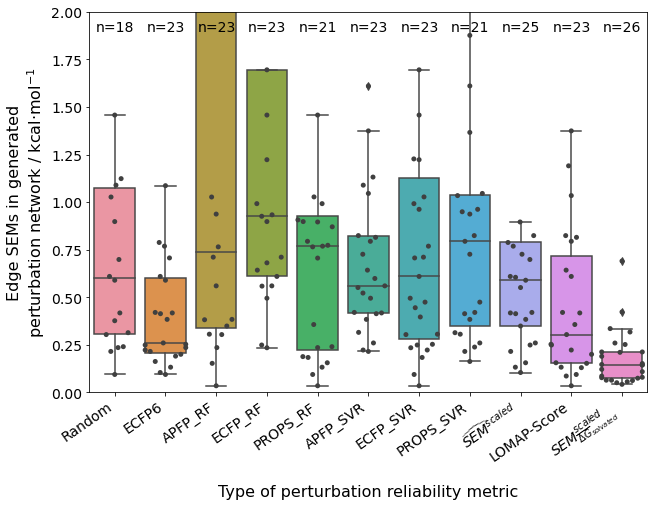

In [18]:
original_true_sems_df = true_df[["pert_name", "true_sem"]]
original_true_sems_df.columns = ["Perturbation", "True SEM"]

true_sems_random, num_edges_random, perts_random = calcTrueSEMS(pert_network_dict_random, original_true_sems_df)
true_sems_pred, num_edges_pred, perts_pred = calcTrueSEMS(pert_network_dict_pred, original_true_sems_df)
true_sems_lomap, num_edges_lomap, perts_lomap = calcTrueSEMS(pert_network_dict_lomap, original_true_sems_df)
true_sems_ecfp6, num_edges_ecfp6, perts_ecfp6 = calcTrueSEMS(pert_network_dict_ecfp6, original_true_sems_df)
true_sems_true, num_edges_true, perts_true = calcTrueSEMS(pert_network_dict_true_sem, original_true_sems_df,
                                                         true_sem_input=True)




true_sems_APFP_RF, num_edges_APFP_RF, perts_APFP_RF = calcTrueSEMS(pert_network_dict_APFP_RF, original_true_sems_df)
true_sems_ECFP_RF, num_edges_ECFP_RF, perts_ECFP_RF = calcTrueSEMS(pert_network_dict_ECFP_RF, original_true_sems_df)
true_sems_PROPS_RF, num_edges_PROPS_RF, perts_PROPS_RF = calcTrueSEMS(pert_network_dict_PROPS_RF, original_true_sems_df)
true_sems_APFP_SVR, num_edges_APFP_SVR, perts_APFP_SVR = calcTrueSEMS(pert_network_dict_APFP_SVR, original_true_sems_df)
true_sems_ECFP_SVR, num_edges_ECFP_SVR, perts_ECFP_SVR = calcTrueSEMS(pert_network_dict_ECFP_SVR, original_true_sems_df)
true_sems_PROPS_SVR, num_edges_PROPS_SVR, perts_PROPS_SVR = calcTrueSEMS(pert_network_dict_PROPS_SVR, original_true_sems_df)



# all wrong; check the naming upstream. 

input_sems_list = [true_sems_random, true_sems_ecfp6, true_sems_APFP_RF, true_sems_ECFP_RF, true_sems_PROPS_RF, true_sems_APFP_SVR, true_sems_ECFP_SVR, true_sems_PROPS_SVR, true_sems_pred, true_sems_lomap, true_sems_true]
input_perts_list = [perts_random, perts_ecfp6, perts_APFP_RF, perts_ECFP_RF, perts_PROPS_RF, perts_APFP_SVR, perts_ECFP_SVR, perts_PROPS_SVR, perts_pred, perts_lomap, perts_true, ]
scoring_types_list = ["Random", "ECFP6", "APFP_RF", "ECFP_RF", "PROPS_RF", "APFP_SVR", "ECFP_SVR", "PROPS_SVR", "$\widehat{SEM}^{scaled}$", "LOMAP-Score", "$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$"]

plotting_dfs = []
for input_sems, input_perts, scoring_type in zip(input_sems_list, input_perts_list, scoring_types_list):
    plotting_dfs.append(toPandasSeaborn(input_sems, input_perts, scoring_type))

concat_df = pd.concat(plotting_dfs, ignore_index=True)


plt.figure(figsize=(10,7))
ax = sns.boxplot(x="SCORING_TYPE", y="SEM", data=concat_df)
ax = sns.swarmplot(x="SCORING_TYPE", y="SEM", data=concat_df, color=".25")


for i, num in enumerate([num_edges_random, num_edges_ecfp6, num_edges_APFP_SVR, num_edges_PROPS_SVR, 
                         num_edges_ECFP_RF, num_edges_APFP_SVR, num_edges_PROPS_SVR, num_edges_ECFP_RF, 
num_edges_pred, num_edges_lomap, num_edges_true]):
    ax.annotate("n="+str(num), xy=(i-0.37,1.9))
    
plt.xlabel("Type of perturbation reliability metric", labelpad=20)
plt.xticks(rotation=35, ha='right') 
plt.ylabel("Edge SEMs in generated\nperturbation network / kcal$\cdot$mol$^{-1}$")
plt.ylim(0, 2)

plt.show()

## Analyse Free Energies vs. Expt per generated network

For all the generated networks, let freenrgworkflows compute ddGs per ligand. Compare this to experimental
binding affinities. See e.g. https://github.com/michellab/BioSimSpaceTutorials/blob/main/04_fep/analyse_fep.ipynb for a guide on using this code.

In [19]:
# import from path (github clone) as a conda install is not available yet for freenrgworkflows.
import sys
sys.path.insert(1, '../../../BioSimSpaceTutorials/04_fep/freenrgworkflows/networkanalysis/')
import networkanalysis as networkanalysis_few
import experiments as experiments_few
import stats as stats_few

In [20]:
intermediate_string = "intermediate_01"

In [21]:
def getTrueSEMs(perturbations, work_path):
    """Given a list of perturbations that contain SEM values, retrieve the True SEM per perturbation and
    write to a file such that it can be used by FreeNrgWorkflows to estimate ddGs."""
    fep_freenrgs_and_sems = pd.read_csv(work_path)

    missing_counter = 0
    with open("process/lomap/freenrgworkflows_input.csv", "w") as writefile:
        writer = csv.writer(writefile)
        for pert in perturbations:
            try:
                # for each pert, find the true freenrg and SEM and generate a summary file for freenrgworkflows.
                lig_1, lig_2 = pert.split("~")
                lig_1_rows = fep_freenrgs_and_sems[fep_freenrgs_and_sems["lig_1"] == lig_1]
                lig_12_row = lig_1_rows[lig_1_rows["lig_2"] == lig_2]
                write_data = lig_12_row.values[0].tolist()

            except IndexError:
                # perturbation SEM not found -> simulation will have failed for this. 
                # Instead, set freenrg to be 5000 and error to be max(SEM)
                write_data = [lig_1, lig_2, 5000, max(fep_freenrgs_and_sems['error'])]
                missing_counter += 1
            writer.writerow(write_data)

        # also write the inverse perturbation.
        for pert in perturbations:
            try:
                lig_2, lig_1 = pert.split("~")
                lig_1_rows = fep_freenrgs_and_sems[fep_freenrgs_and_sems["lig_1"] == lig_1]
                lig_12_row = lig_1_rows[lig_1_rows["lig_2"] == lig_2]
                write_data = lig_12_row.values[0].tolist()
            except IndexError:
                # perturbation SEM not found -> simulation will have failed for this. 
                # Instead, set freenrg to be 5000 and error to be max(SEM)
                write_data = [lig_1, lig_2, 5000, max(fep_freenrgs_and_sems['error'])]
            
            writer.writerow(write_data)

    return "process/lomap/freenrgworkflows_input.csv", missing_counter


In [22]:
def computeRelativeDDGs(input_path):
    """Uses FreeNrgWorkFlows to estimate per-ligand DDGs based on the provided network edge freenrgs and errors."""
    nA = networkanalysis_few.NetworkAnalyser()
    nA.read_perturbations_pandas(input_path, comments='#')

    computed_relative_DDGs = nA.freeEnergyInKcal
    
    return computed_relative_DDGs

In [23]:
def computeExptDDGs(expt_path, data_type):
    """Uses FreeNrgWorkFlows to estimate experimental per-ligand DDGs based on 
    the provided network edge freenrgs and errors."""
        
    experiments_obj = experiments_few.ExperimentalData()

    experiments_obj.compute_affinities(expt_path, data_type=data_type, comments="#", delimiter=",")
    experimental_DDGs = experiments_obj.freeEnergiesInKcal
    
    return experimental_DDGs

In [24]:
def getFreenrgDict(computed_relative_DDGs, experimental_DDGs):
    """Merges together FEP and experimental DDG predictions for easier analysis."""
    freenrg_dict = {}

    # construct dict with experimental freenrg and error.
    for item in experimental_DDGs:
        ligand = list(item.keys())[0]
        freenrg = list(item.values())[0]
        error = list(item.values())[1]
        freenrg_dict[ligand] = [freenrg, error]

    # append computed freenrg and error.
    for item in computed_relative_DDGs:
            ligand = list(item.keys())[0]
            freenrg = list(item.values())[0]
            error = list(item.values())[1]

            if intermediate_string not in ligand:
                freenrg_dict[ligand].append(freenrg)
                freenrg_dict[ligand].append(error)
    freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()
    return freenrg_df

In [33]:
def plotPredictions(freenrg_df, computed_relative_DDGs,experimental_DDGs, title, n_perts, ax, num_failed_edges=False, is_base=False):
    """Plots a scatterplot of FEP vs EXP as well as a table of statistics."""
    
    stats_to_return = []
    ax.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

    # plot 1/2 kcal bounds:
    ax.fill_between(
                    x=[-100, 100], 
                    y2=[-100.25,99.75],
                    y1=[-99.75, 100.25],
                    lw=0, 
                    zorder=-10,
                    alpha=0.3,
                    color="grey")
    # upper bound:
    ax.fill_between(
                    x=[-100, 100], 
                    y2=[-99.5,100.5],
                    y1=[-99.75, 100.25],
                    lw=0, 
                    zorder=-10,
                    color="grey", 
                    alpha=0.2)
    # lower bound:
    ax.fill_between(
                    x=[-100, 100], 
                    y2=[-100.25,99.75],
                    y1=[-100.5, 99.5],
                    lw=0, 
                    zorder=-10,
                    color="grey", 
                    alpha=0.2)

    # plot error bars:
    yerr = freenrg_df["err_fep"]
    xerr = freenrg_df["err_exp"]
    if not is_base:
        ax.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
                    yerr=yerr,
                    xerr=xerr,   # comment this line to hide experimental error bars \
                                 # as this can sometimes overcrowd the plot.
                    ls="none",
                    lw=0.5, 
                    capsize=2,
                    color="black",
                    zorder=5
                    )

        # format the plot further.
        ax.axhline(color="black", zorder=-11)
        ax.axvline(color="black", zorder=-11)

    # get the bounds. This can be done with min/max or simply by hand.
    all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])

    # for a scatterplot we want the axis ranges to be the same. 
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)

    #plt.savefig("outputs/fep_vs_exp_scatterplot.png", dpi=300)
    
    
    _stats = stats_few.freeEnergyStats()
    _stats.generate_statistics(computed_relative_DDGs,experimental_DDGs,repeats=100000)
    r_confidence = _stats.R_confidence
    tau_confidence = _stats.tau_confidence
    mue_confidence = _stats.mue_confidence
    
    ax.annotate(f"n edges: {n_perts}", xy=(0.05, 0.9), xycoords='axes fraction')
    stats_to_return.append([r_confidence[1], r_confidence[0], r_confidence[2]])
    stats_to_return.append([mue_confidence[1], mue_confidence[0], mue_confidence[2]])
    stats_to_return.append([tau_confidence[1], tau_confidence[0], tau_confidence[2]])
    
    if num_failed_edges:
        ax.annotate(num_failed_edges, xy=(0.9, 0.05), color='red', fontsize=25,xycoords='axes fraction')
    ax.set_title(title)
    ax.grid(False)
    
    return stats_to_return

In [34]:
def computePM(stats_triplet):
    """For a list of three values where the middle value is the mean and the outer values are the outer bounds,
    return the mean and the plus-minus as the mean error of the bounds compared to the mean."""
    mean_val = stats_triplet[1]
    error_1 = mean_val - stats_triplet[0]
    error_2 = stats_triplet[2] - mean_val 
    mean_err = np.mean([error_1, error_2])
    
    return round(mean_val, 2), round(mean_err, 2)

RANDOM
APFP_SVR
ECFP6 Tanimoto
$\widehat{SEM}^{scaled}$
LOMAP-Score
$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$


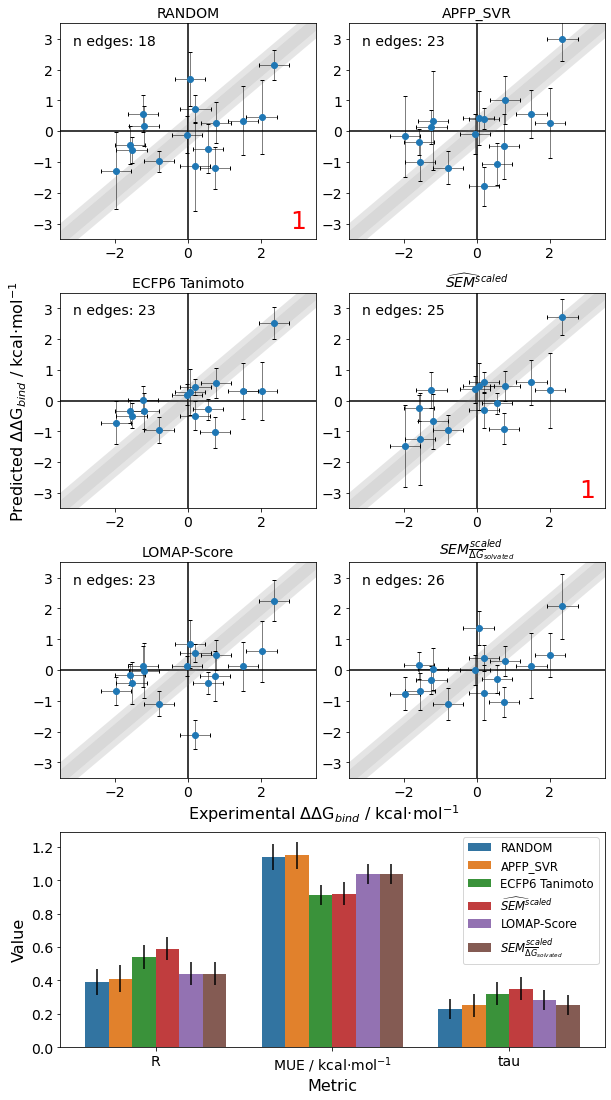

In [35]:
grid = GridSpec(4, 2,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.13, hspace=0.25)

fig = plt.figure(figsize=(9, 18))

ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1])
ax5 = fig.add_subplot(grid[2, 0])
ax6 = fig.add_subplot(grid[2, 1])


pred_collections = [perts_random, perts_APFP_SVR, perts_ecfp6, perts_pred, perts_lomap, perts_true]
pred_types = ["RANDOM", "APFP_SVR", "ECFP6 Tanimoto", "$\widehat{SEM}^{scaled}$", "LOMAP-Score", "$SEM^{scaled}_{\overline{\Delta{G}}_{solvated}}$"]
returned_stats_coll = []

for perts, title, ax in zip(pred_collections, pred_types, [ax1,
                                                                ax2,
                                                                ax3,
                                                                ax4,
                                                                ax5,
                                                                ax6]):
    print(title)
    
    # get the true SEMs for all the used edges for this protocol.
    n_perts = len(perts)
    freenrgworkflows_input_path, num_failed_edges = getTrueSEMs(perts, "input/testsets/tyk2/ALL_TRUE_SEMS_BI_PROPD.csv")
    
    # use FEW to estimate per-ligand DDGs for both FEP and EXPT
    computed_relative_DDGs = computeRelativeDDGs(freenrgworkflows_input_path)
    experimental_DDGs = computeExptDDGs("input/testsets/tyk2/exp_data_tyk2.dat", "IC50")
    
    # Plot this protocol into a subplot.
    freenrg_df = getFreenrgDict(computed_relative_DDGs, experimental_DDGs)
    returned_stats = plotPredictions(freenrg_df, computed_relative_DDGs, experimental_DDGs, title, n_perts, ax, num_failed_edges)
    
    returned_stats = [computePM(stats) for stats in returned_stats]
    returned_stats_coll.append(returned_stats)
    
# plot statistics on the bottom plot.
seaborn_data = [["Input", "Metric", "Value", "+/-"]]
for method, stats in zip(pred_types, returned_stats_coll):
    st_types = ["R", "MUE / kcal$\cdot$mol$^{-1}$", "tau"]
    for st, typ in zip(stats, st_types):
        seaborn_data.append([method, typ, st[0], st[1]])
        
seaborn_data_df = pd.DataFrame(seaborn_data[1:],columns=seaborn_data[0])

ax7 = fig.add_subplot(grid[3, :])
ax_tr = sns.barplot(x="Metric", y="Value", hue="Input", 
                    data=seaborn_data_df, ax=ax7)

x_coords = [p.get_x() + 0.5*p.get_width() for p in ax_tr.patches]
y_coords = [p.get_height() for p in ax_tr.patches]
ax_tr.errorbar(x=x_coords, y=y_coords, yerr=seaborn_data_df["+/-"], fmt="none", c= "k")

# remove title from legend. 
handles, labels = ax7.get_legend_handles_labels()
ax7.legend(handles=handles[0:], labels=labels[0:],fontsize='small')

# some final layout touches on the whole plot.
ax3.set_ylabel("Predicted $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
ax5.set_xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$", ha='left')
plt.tight_layout()

#savefig?
plt.show()